# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv`. The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Ann Arbor, Michigan, United States**, and the stations the data comes from are shown on the map below.

In [1]:
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd
import datetime as dt
import numpy as np

In [2]:
def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('data/C2A2_data/BinSize_d{}.csv'.format(binsize))

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    plt.figure(figsize=(8,8))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return mplleaflet.display()

leaflet_plot_stations(400,'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89')

### Preparing the data

In [3]:
def get_meta_data(binsize,hashid):
    df = pd.read_csv('data/C2A2_data/BinSize_d{}.csv'.format(binsize))
    station_locations_by_hash_meta = df[df['hash'] == hashid]
    return station_locations_by_hash_meta

def get_temperature_data(binsize,hashid):
    df = pd.read_csv('data/C2A2_data/BinnedCsvs_d{}/{}.csv'.format(binsize,hashid))
    return df

In [4]:
#Function calls to get dataframes
binsize = 400
hashid = 'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89'
meta_data = get_meta_data(binsize,hashid)
temp_data = get_temperature_data(binsize,hashid)

In [5]:
#Merge the two datasets to get required fields.
all_data = pd.merge(meta_data[['ID']],temp_data,on='ID').sort_values(by=['ID','Date']).reset_index(drop = True)
all_data['Data_Value'] =all_data['Data_Value'].apply(lambda x: x/10) #Since temperature has been given in tenths of degree centigrade
all_data['Date'] = pd.to_datetime(all_data['Date']) #Converting date column values in datetime format
all_data.head()

,ID,Date,Element,Data_Value
0,USC00200032,2005-01-01,TMIN,-2.8
1,USC00200032,2005-01-01,TMAX,6.7
2,USC00200032,2005-01-02,TMAX,12.2
3,USC00200032,2005-01-02,TMIN,-0.6
4,USC00200032,2005-01-03,TMIN,1.1


In [6]:
#To find the max and min temperatures over a period of 9 years for each calendar day. 
date_month_year_level = all_data.groupby(['Date'])['Data_Value'].agg(['max','min']).reset_index()

#Extracting Year,Month and Day from Date column which will be used in next round of grouping and aggregation
date_month_year_level['Year'] = date_month_year_level['Date'].apply(lambda x: x.strftime('%Y')).astype(int)
date_month_year_level['Month'] = date_month_year_level['Date'].apply(lambda x: x.strftime('%m'))
date_month_year_level['Day'] = date_month_year_level['Date'].apply(lambda x: x.strftime('%d'))

#Removing leap year rows
date_month_year_level =  date_month_year_level.drop(date_month_year_level[(date_month_year_level['Month'] == '02') & (date_month_year_level['Day'] == '29')].index)


#Filtering for upto 2014
date_month_year_level_upto_2014 = date_month_year_level.loc[date_month_year_level['Year'] <2015]

#Filtering for 2015
date_month_year_level_2015 = date_month_year_level.loc[date_month_year_level['Year'] == 2015]


def group_by_func(df):
    #Grouping by day and month
    grouped_data_frame = df.groupby(['Month','Day']).agg({'max':max,'min':min}).reset_index().rename(columns = {'max':'Max_Temperature','min':'Min_Temperature'})
    return grouped_data_frame

day_month_upto_2014 = group_by_func(date_month_year_level_upto_2014)   
day_month_2015 = group_by_func(date_month_year_level_2015)   


### Plotting the data

In [7]:
#Listing x tick labels to set them later
x_tick_list = day_month_upto_2014[day_month_upto_2014['Day'] == '01'].index.tolist() #Setting ticks to 1st day of every month.
month_list = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'] #Once we have tick positions, they can be labeled with month names

#Listing only those points in 2015 whose max value exceeds max of past 9 years and min value falls below min of past 9 years
max_2015 = day_month_2015[day_month_2015['Max_Temperature'] > day_month_upto_2014['Max_Temperature']]
min_2015 = day_month_2015[day_month_2015['Min_Temperature'] < day_month_upto_2014['Min_Temperature']]

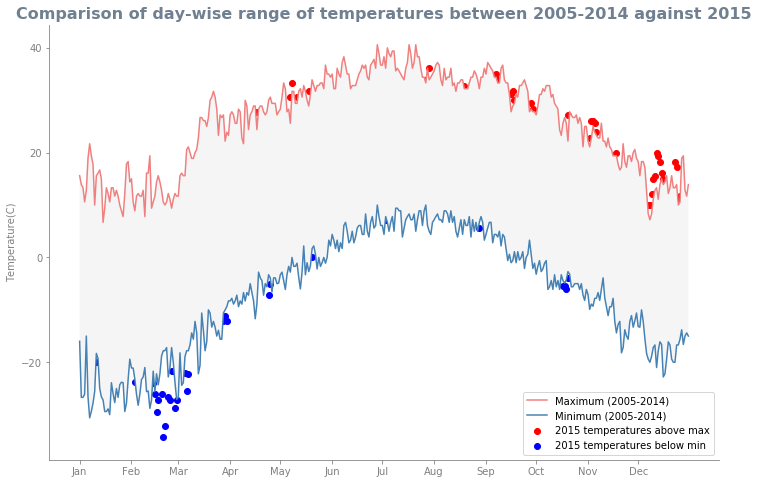

In [8]:
plt.figure(figsize =(12,8))
#Line plots
plt.plot(day_month_upto_2014['Max_Temperature'].tolist(),color ='lightcoral')
plt.plot(day_month_upto_2014['Min_Temperature'].tolist(),color ='steelblue')

#Scatter plot
plt.scatter(max_2015.index.tolist(),max_2015['Max_Temperature'],color ='r')
plt.scatter(min_2015.index.tolist(),min_2015['Min_Temperature'],color ='b')

#Spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_color('grey')
plt.gca().spines['left'].set_color('grey')

#Axis labeling and formatting
plt.ylabel('Temperature(C)',color = 'grey')
plt.xticks(x_tick_list)
plt.yticks([-40,-20,0,20,40],color ='grey')
plt.gca().set_xticklabels(month_list,color = 'grey')
plt.gca().tick_params(color = 'grey')

#legend and title
plt.legend(['Maximum (2005-2014)','Minimum (2005-2014)','2015 temperatures above max','2015 temperatures below min'])
plt.title('Comparison of day-wise range of temperatures between 2005-2014 against 2015',size = 16,fontweight = 'heavy',color = 'slategray')

#Filling the region between the two lines
plt.fill_between(day_month_upto_2014.index.tolist(), day_month_upto_2014['Max_Temperature'].tolist(), day_month_upto_2014['Min_Temperature'].tolist(),facecolor = 'whitesmoke')

#plt.savefig('Assignment_2_Temperature_Range_Graph.jpg')
plt.show()